### DEBUGing torsion tree issue

#### Step 1 - define all the functions needed

In [20]:


from AutoDockTools.AutoDockBondClassifier import AutoDockBondClassifier
from MolKit.molecule import AtomSet
from MolKit.torTree import TorTree

def get_tor_tree_nodes(ligand_tor_tree):
    N = []
    current_level = [ligand_tor_tree.rootNode]
    while current_level:
        next_level = [c for n in current_level for c in n.children]
        N.extend(next_level)
        current_level = next_level
    return N

def check_tor_tree(node, parent=None):
    if parent and node.bond[1] not in parent.atomList:
        parent.atomList.append(node.bond[1])
    for child in node.children:
        check_tor_tree(child, node)
        
def make_tor_tree(fragment, root_name, ligand=None, previous_fragment=None):
    # classify all the fragment's bonds, and initialize their attributes
    classes = AutoDockBondClassifier().classify(fragment.allAtoms.bonds[0])
    fragment.allAtoms.bonds[
        0
    ].possibleTors = False  # bond associated with a possible torsion
    fragment.allAtoms.bonds[
        0
    ].activeTors = False  # bond associated with an active torsion
    fragment.allAtoms.bonds[0].incycle = False  # bond that belongs to a cycle
    fragment.allAtoms.bonds[0].hrotator = False  # bond that rotates only hydrogens
    fragment.allAtoms.bonds[0].amdbond = False  # amide bond

    # set the values of the fragment's bond attributes, based on the classification
    classes["cycle"].incycle = True
    classes["amide"].amdbond = True
    for a in classes["hydrogenRotators"]:  # this class contains atoms, not bonds
        a.bonds.get(lambda b: b.neighborAtom(a).element != "H").hrotator = True
    torsions = classes["rotatable"].get(
        lambda b: not (b.incycle or b.amdbond or b.hrotator)
    )

    # if the ligand has been provided, use it to check the fragment's torsions
    # (in some cases, the fragment might have torsions that are not in the ligand)
    if ligand:
        ligand_torsions = [b for b in ligand.allAtoms.bonds[0] if b.possibleTors]
        for tor in torsions:
            tor_atoms = set([tor.atom1.name, tor.atom2.name])
            if not [
                b
                for b in ligand_torsions
                if set([b.atom1.name, b.atom2.name]) == tor_atoms
            ]:
                torsions.remove(tor)

    # if the previous fragment has been provided,
    # check that all its possible torsions are in the current fragment's torsion tree
    if previous_fragment:
        for tor in [b for b in previous_fragment.allAtoms.bonds[0] if b.possibleTors]:
            bond = next(
                b
                for b in fragment.allAtoms.bonds[0]
                if set([b.atom1.name, b.atom2.name])
                == set([tor.atom1.name, tor.atom2.name])
            )
            if bond not in torsions:
                torsions.append(bond)

    # create the fragment's torsion tree
    torsions.possibleTors = True
    torsions.activeTors = True
    fragment.TORSDOF = len(torsions)  # number of possible torsions
    fragment.torscount = len(torsions)  # number of active torsions
    fragment.ROOT = next(a for a in fragment.allAtoms if a.name == root_name)
    fragment.ROOT.rnum0 = 0

    fragment.torTree = TorTree(fragment.parser, fragment.ROOT)

    # check that the torsion tree has been properly built
    check_tor_tree(fragment.torTree.rootNode)

    # sort the fragment's atoms based on their index in the torsion tree
    # (this is needed because of how StateToCoords works; see mglutil.math.statetocoords)
    fragment.allAtoms = AtomSet(
        sorted(
            fragment.allAtoms, key=lambda a: a.tt_ind if hasattr(a, "tt_ind") else False
        )
    )

#### Step 2 - Load ligands

In [1]:
from dinc_ensemble import *
from dinc_ensemble.ligand.core.convert_molecule import *

In [2]:
#ligand_new_load = load_ligand("./data/pdbbind_test_ligands/3atl_ligand_dof_1.sdf")

op_1074_dinc_mol = load_ligand("./data/5ufx_lig_A.sdf")

[17:53:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


[{'_molkit_bond': <Bond instance '5ufx_lig_Ameeko_setup_0: :UNL1:O == 5ufx_lig_Ameeko_setup_0: :UNL1:C','1'>, '_atom1': Atom(_molkit_atom=<Atom instance> 5ufx_lig_Ameeko_setup_0: :UNL1:O, _molkit_bonds=<BondSet instance> holding 2 Bond, "5ufx_lig_Ameeko_setup_0: :UNL1...", _conformations=AtomConformations(selected_conformation=0, confs=array([[-2.212, -2.497, -0.612]]), molkit_full_name='5ufx_lig_Ameeko_setup_0: :UNL1:O.6'), molkit_full_name='5ufx_lig_Ameeko_setup_0: :UNL1:O.6', number=7, element='O', organic=1, charge=AtomCharge(selected_charge='pdbqt', charges={'pdbqt': -0.492})), '_atom2': Atom(_molkit_atom=<Atom instance> 5ufx_lig_Ameeko_setup_0: :UNL1:C, _molkit_bonds=<BondSet instance> holding 3 Bond, "5ufx_lig_Ameeko_setup_0: :UNL1...", _conformations=AtomConformations(selected_conformation=0, confs=array([[-1.083, -1.838, -0.227]]), molkit_full_name='5ufx_lig_Ameeko_setup_0: :UNL1:C.0'), molkit_full_name='5ufx_lig_Ameeko_setup_0: :UNL1:C.0', number=1, element='C', organic=1, ch

In [3]:
op_1074_dinc_mol._meeko_pdbqt_file

'./data/5ufx_lig_Ameeko_setup_0.pdbqt'

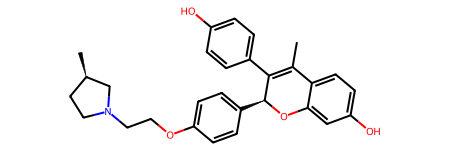

In [4]:
rdkit_mol = to_rdkit(op_1074_dinc_mol, flatten=True)
rdkit_mol

In [5]:
op_1074_dinc_mol

DINCMolecule(molkit_molecule=<Protein instance> 5ufx_lig_Ameeko_setup_0 with 1 <class 'MolKit.protein.Chain'>, _meeko=True, _meeko_pdbqt_file='./data/5ufx_lig_Ameeko_setup_0.pdbqt', _meeko_rdkit_molecule=<rdkit.Chem.rdchem.Mol object at 0x7efbc5b84040>, _meeko_mol_setups=<meeko.molsetup.RDKitMoleculeSetup object at 0x7efc389f9f50>, _atoms=array([Atom(_molkit_atom=<Atom instance> 5ufx_lig_Ameeko_setup_0: :UNL1:C, _molkit_bonds=<BondSet instance> holding 3 Bond, "5ufx_lig_Ameeko_setup_0: :UNL1...", _conformations=AtomConformations(selected_conformation=0, confs=array([[-1.083, -1.838, -0.227]]), molkit_full_name='5ufx_lig_Ameeko_setup_0: :UNL1:C.0'), molkit_full_name='5ufx_lig_Ameeko_setup_0: :UNL1:C.0', number=1, element='C', organic=1, charge=AtomCharge(selected_charge='pdbqt', charges={'pdbqt': 0.119})),
       Atom(_molkit_atom=<Atom instance> 5ufx_lig_Ameeko_setup_0: :UNL1:C, _molkit_bonds=<BondSet instance> holding 2 Bond, "5ufx_lig_Ameeko_setup_0: :UNL1...", _conformations=AtomCon

In [111]:
wrong_bond = op_1074_dinc_mol.molkit_molecule.allAtoms.bonds[0][7]
wrong_bond.__dict__

{'setClass': MolKit.molecule.BondSet,
 'atom1': <Atom instance> 5ufx_lig_Ameeko_setup_0: :UNL1:C,
 'atom2': <Atom instance> 5ufx_lig_Ameeko_setup_0: :UNL1:C,
 'name': '5ufx_lig_Ameeko_setup_0: :UNL1:C == 5ufx_lig_Ameeko_setup_0: :UNL1:C',
 'children': [],
 'bondOrder': 1,
 'origin': 'UserDefined',
 'shared': 0,
 'incycle': True,
 'amdbond': False,
 'hrotator': False,
 'activeTors': False,
 'possibleTors': False,
 'initialized': True}

In [113]:
from PyBabel.cycle import RingFinder

In [115]:
rf = RingFinder()

In [116]:
ol.molkit_molecule.allAtoms, op_1074_dinc_mol.molkit_molecule.allAtoms.bonds[0])rf.findRings2(op_1074_dinc_m

In [121]:
len(rf.allRingBonds)

28

In [122]:
from MolKit.molecule import Bond, BondSet
ats = BondSet(rf.allRingBonds).getAtoms()
ANS = {}
for a in ats:
    for b in a.bonds:
        if b.atom1 in ats and b.atom2 in ats:
            ANS[b] = 1
#return BondSet(rf.allRingBonds)
bonds= BondSet(list(ANS.keys()))

In [123]:
len(bonds)

30

In [118]:
[b for b in rf.allRingBonds if b == wrong_bond]

[]

In [119]:
wrong_bond == wrong_bond

True

In [103]:
op_1074_dinc_mol.bonds.iloc[7]

atom1_molkit_full_name     5ufx_lig_Ameeko_setup_0: :UNL1:C.5
atom2_molkit_full_name    5ufx_lig_Ameeko_setup_0: :UNL1:C.15
origin                                            UserDefined
bond_order                                                  1
incycle_                                                 True
hrotator_                                               False
amdbond_                                                False
possibleTors_                                           False
activeTors_                                             False
idx_atom1                                                   5
idx_atom2                                                  15
Name: 7, dtype: object

In [100]:
[t.__dict__ for t in op_1074_dinc_mol.molkit_molecule.torTree.torsionMap]

[{'parent': <mglutil.util.tree.TreeNode at 0x7fc50414b210>,
  'children': [],
  'number': 7,
  'bond': (31, 32),
  'atomList': [33],
  'atoms_to_move': 1},
 {'parent': <mglutil.util.tree.TreeNode at 0x7fc50414a950>,
  'children': [],
  'number': 8,
  'bond': (23, 34),
  'atomList': [35],
  'atoms_to_move': 1},
 {'parent': <mglutil.util.tree.TreeNode at 0x7fc50414a9d0>,
  'children': [],
  'number': 4,
  'bond': (8, 9),
  'atomList': [10, 11, 12, 13, 14],
  'atoms_to_move': 5},
 {'parent': <mglutil.util.tree.TreeNode at 0x7fc50414aa50>,
  'children': [<mglutil.util.tree.TreeNode at 0x7fc50414a850>],
  'number': 3,
  'bond': (7, 8),
  'atomList': [9],
  'atoms_to_move': 6},
 {'parent': <mglutil.util.tree.TreeNode at 0x7fc50414a490>,
  'children': [<mglutil.util.tree.TreeNode at 0x7fc50414a9d0>],
  'number': 2,
  'bond': (6, 7),
  'atomList': [8],
  'atoms_to_move': 7},
 {'parent': <mglutil.util.tree.TreeNode at 0x7fc50414a950>,
  'children': [<mglutil.util.tree.TreeNode at 0x7fc50414a8d0

In [99]:
len(op_1074_dinc_mol.molkit_molecule.torTree.torsionMap)

8

{15: 1, 14: 2, 13: 3, 25: 4, 26: 5, 12: 6, 16: 7, 17: 8, 18: 9, 19: 10, 24: 11, 22: 12, 23: 13, 21: 14, 20: 15, 11: 16, 27: 17, 3: 18, 28: 19, 2: 20, 29: 21, 34: 22, 1: 23, 30: 24, 33: 25, 32: 26, 4: 27, 5: 28, 10: 29, 6: 30, 9: 31, 7: 32, 8: 33, 31: 35}
{1: 15, 2: 14, 3: 13, 4: 25, 5: 26, 6: 12, 7: 16, 8: 17, 9: 18, 10: 19, 11: 24, 12: 22, 13: 23, 14: 21, 15: 20, 16: 11, 17: 27, 18: 3, 19: 28, 20: 2, 21: 29, 22: 34, 23: 1, 24: 30, 25: 33, 26: 32, 27: 4, 28: 5, 29: 10, 30: 6, 31: 9, 32: 7, 33: 8, 35: 31}
0       [6, 0]
7      [5, 15]
8       [7, 6]
9       [8, 7]
10      [9, 8]
21    [17, 26]
dtype: object
[<rdkit.Chem.rdchem.Bond object at 0x7efbc42af290>, <rdkit.Chem.rdchem.Bond object at 0x7efbc42af220>, <rdkit.Chem.rdchem.Bond object at 0x7efbc42af300>, <rdkit.Chem.rdchem.Bond object at 0x7efbc42af450>, <rdkit.Chem.rdchem.Bond object at 0x7efbc42aef10>, <rdkit.Chem.rdchem.Bond object at 0x7efbc42afd80>]


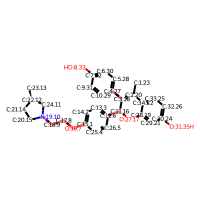

In [9]:
draw_bond_property_rdkit(op_1074_dinc_mol, 
                         op_1074_dinc_mol.bonds.possibleTors_==True)

In [17]:
op_1074_dinc_mol.bonds[op_1074_dinc_mol.bonds.possibleTors_==True]

,atom1_molkit_full_name,atom2_molkit_full_name,origin,bond_order,incycle_,hrotator_,amdbond_,possibleTors_,activeTors_,idx_atom1,idx_atom2
0,5ufx_lig_Ameeko_setup_0: :UNL1:O.6,5ufx_lig_Ameeko_setup_0: :UNL1:C.0,UserDefined,1,False,False,False,True,False,6,0
8,5ufx_lig_Ameeko_setup_0: :UNL1:C.7,5ufx_lig_Ameeko_setup_0: :UNL1:O.6,UserDefined,1,False,False,False,True,False,7,6
9,5ufx_lig_Ameeko_setup_0: :UNL1:C.8,5ufx_lig_Ameeko_setup_0: :UNL1:C.7,UserDefined,1,False,False,False,True,False,8,7
10,5ufx_lig_Ameeko_setup_0: :UNL1:N.9,5ufx_lig_Ameeko_setup_0: :UNL1:C.8,UserDefined,1,False,False,False,True,False,9,8


In [14]:
op_1074_dinc_mol.bonds[op_1074_dinc_mol.bonds.possibleTors_==True]

,atom1_molkit_full_name,atom2_molkit_full_name,origin,bond_order,incycle_,hrotator_,amdbond_,possibleTors_,activeTors_,idx_atom1,idx_atom2
0,5ufx_lig_Ameeko_setup_0: :UNL1:O.6,5ufx_lig_Ameeko_setup_0: :UNL1:C.0,UserDefined,1,False,False,False,True,False,6,0
8,5ufx_lig_Ameeko_setup_0: :UNL1:C.7,5ufx_lig_Ameeko_setup_0: :UNL1:O.6,UserDefined,1,False,False,False,True,False,7,6
9,5ufx_lig_Ameeko_setup_0: :UNL1:C.8,5ufx_lig_Ameeko_setup_0: :UNL1:C.7,UserDefined,1,False,False,False,True,False,8,7
10,5ufx_lig_Ameeko_setup_0: :UNL1:N.9,5ufx_lig_Ameeko_setup_0: :UNL1:C.8,UserDefined,1,False,False,False,True,False,9,8


In [12]:
[node.__dict__ for node in op_1074_dinc_mol.molkit_molecule.torTree.torsionMap]

[{'parent': <mglutil.util.tree.TreeNode at 0x7f120a377ad0>,
  'children': [],
  'number': 7,
  'bond': (31, 32),
  'atomList': [33],
  'atoms_to_move': 1},
 {'parent': <mglutil.util.tree.TreeNode at 0x7f120a377dd0>,
  'children': [],
  'number': 8,
  'bond': (23, 34),
  'atomList': [35],
  'atoms_to_move': 1},
 {'parent': <mglutil.util.tree.TreeNode at 0x7f120a377e50>,
  'children': [],
  'number': 4,
  'bond': (8, 9),
  'atomList': [10, 11, 12, 13, 14],
  'atoms_to_move': 5},
 {'parent': <mglutil.util.tree.TreeNode at 0x7f120a3777d0>,
  'children': [<mglutil.util.tree.TreeNode at 0x7f120a377950>],
  'number': 3,
  'bond': (7, 8),
  'atomList': [9],
  'atoms_to_move': 6},
 {'parent': <mglutil.util.tree.TreeNode at 0x7f120a377f90>,
  'children': [<mglutil.util.tree.TreeNode at 0x7f120a377e50>],
  'number': 2,
  'bond': (6, 7),
  'atomList': [8],
  'atoms_to_move': 7},
 {'parent': <mglutil.util.tree.TreeNode at 0x7f120a377dd0>,
  'children': [<mglutil.util.tree.TreeNode at 0x7f120a3779d0

In [6]:
ligand_new_load.bonds

,atom1_molkit_full_name,atom2_molkit_full_name,origin,bond_order,incycle_,hrotator_,amdbond_,possibleTors_,activeTors_,idx_atom1,idx_atom2
0,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.0,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.1,UserDefined,2,True,False,False,False,False,0,1
1,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.0,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.5,UserDefined,1,True,False,False,False,False,0,5
2,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.0,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.6,UserDefined,1,False,False,False,True,False,0,6
3,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.1,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.2,UserDefined,1,True,False,False,False,False,1,2
4,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.2,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.3,UserDefined,2,True,False,False,False,False,2,3
5,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.3,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.4,UserDefined,1,True,False,False,False,False,3,4
6,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.4,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.5,UserDefined,2,True,False,False,False,False,4,5
7,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.6,3atl_ligand_dof_1meeko_setup_0: :UNL1:N.7,UserDefined,1,False,True,False,False,False,6,7
8,3atl_ligand_dof_1meeko_setup_0: :UNL1:C.6,3atl_ligand_dof_1meeko_setup_0: :UNL1:N.8,UserDefined,2,False,True,False,False,False,6,8
9,3atl_ligand_dof_1meeko_setup_0: :UNL1:N.7,3atl_ligand_dof_1meeko_setup_0: :UNL1:H.9,UserDefined,1,False,False,False,False,False,7,9


In [42]:
from dinc_ensemble.ligand.io.ligand_specific_loaders import LigandSDFLoader
from MolKit import Read
ligand_mol2_load = Read("./data/pdbbind_test_ligands/3atl_ligand_dof_1.mol2")
ligand_mol2 = DINCMolecule(ligand_mol2_load)
#ligand_old_load = LigandSDFLoader.load("./data/pdbbind_test_ligands/3atl_ligand_dof_1.sdf")

[{'_molkit_bond': <Bond instance '3atl_ligand_dof_1:default:BEN1:C1 == 3atl_ligand_dof_1:default:BEN1:C2','2'>, '_atom1': Atom(_molkit_atom=<Atom instance> 3atl_ligand_dof_1:default:BEN1:C1, _molkit_bonds=<BondSet instance> holding 3 Bond, "3atl_ligand_dof_1:default:BEN1...", _conformations=AtomConformations(selected_conformation=0, confs=array([[ -1.777, -14.186,  16.808]]), molkit_full_name='3atl_ligand_dof_1:default:BEN1:C1.0'), molkit_full_name='3atl_ligand_dof_1:default:BEN1:C1.0', number=1, element='C', organic=1, charge=AtomCharge(selected_charge='mol2', charges={'mol2': 0.026})), '_atom2': Atom(_molkit_atom=<Atom instance> 3atl_ligand_dof_1:default:BEN1:C2, _molkit_bonds=<BondSet instance> holding 3 Bond, "3atl_ligand_dof_1:default:BEN1...", _conformations=AtomConformations(selected_conformation=0, confs=array([[ -2.112, -15.538,  16.692]]), molkit_full_name='3atl_ligand_dof_1:default:BEN1:C2.1'), molkit_full_name='3atl_ligand_dof_1:default:BEN1:C2.1', number=2, element='C', or

In [43]:
ligand_mol2.bonds

,atom1_molkit_full_name,atom2_molkit_full_name,origin,bond_order,incycle_,hrotator_,amdbond_,possibleTors_,activeTors_,idx_atom1,idx_atom2
0,3atl_ligand_dof_1:default:BEN1:C1.0,3atl_ligand_dof_1:default:BEN1:C2.1,File,2,True,False,False,False,False,0,1
1,3atl_ligand_dof_1:default:BEN1:C1.0,3atl_ligand_dof_1:default:BEN1:C6.5,File,1,True,False,False,False,False,0,5
2,3atl_ligand_dof_1:default:BEN1:C1.0,3atl_ligand_dof_1:default:BEN1:C.6,File,1,False,False,False,True,False,0,6
3,3atl_ligand_dof_1:default:BEN1:C2.1,3atl_ligand_dof_1:default:BEN1:C3.2,File,1,True,False,False,False,False,1,2
4,3atl_ligand_dof_1:default:BEN1:C2.1,3atl_ligand_dof_1:default:BEN1:H1.9,File,1,False,False,False,False,False,1,9
5,3atl_ligand_dof_1:default:BEN1:C3.2,3atl_ligand_dof_1:default:BEN1:C4.3,File,2,True,False,False,False,False,2,3
6,3atl_ligand_dof_1:default:BEN1:C3.2,3atl_ligand_dof_1:default:BEN1:H2.10,File,1,False,False,False,False,False,2,10
7,3atl_ligand_dof_1:default:BEN1:C4.3,3atl_ligand_dof_1:default:BEN1:C5.4,File,1,True,False,False,False,False,3,4
8,3atl_ligand_dof_1:default:BEN1:C4.3,3atl_ligand_dof_1:default:BEN1:H3.11,File,1,False,False,False,False,False,3,11
9,3atl_ligand_dof_1:default:BEN1:C5.4,3atl_ligand_dof_1:default:BEN1:C6.5,File,2,True,False,False,False,False,4,5


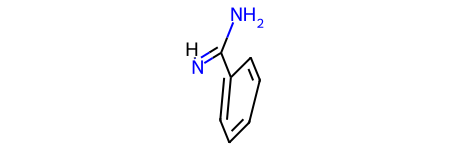

In [45]:
to_rdkit(ligand_new_load)

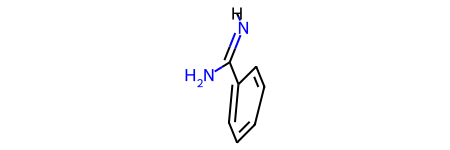

In [46]:
to_rdkit(ligand_mol2)

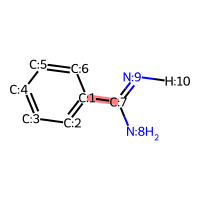

In [47]:
draw_bond_property_rdkit(ligand_new_load, 
                         ligand_new_load.bonds.possibleTors_==True)

In [ ]:
draw_bond_property_rdkit(ligand_new_load, 
                         ligand_new_load.bonds.possibleTors_==True)

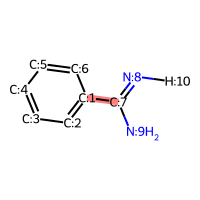

In [48]:
draw_bond_property_rdkit(ligand_mol2, 
                         ligand_mol2.bonds.possibleTors_==True)

In [51]:
make_tor_tree(ligand_new_load.molkit_molecule, "C")

Building tree
Root atom
{'children': <TreeNodeSet instance> empty, 'setClass': <class 'MolKit.molecule.AtomSet'>, 'childrenSetClass': <class 'MolKit.tree.TreeNodeSet'>, 'childrenName': None, 'name': 'C', 'elementType': None, 'parent': <Residue instance> 3atl_ligand_dof_1meeko_setup_0: :UNL1 with 12 <class 'MolKit.molecule.Atom'>, '_uniqIndex': 0, 'top': <Protein instance> 3atl_ligand_dof_1meeko_setup_0 with 1 <class 'MolKit.protein.Chain'>, 'childByName': {}, 'alias': None, 'conformation': 0, 'element': 'C', 'chemElem': 'C', 'atomicNumber': 6, 'bondOrderRadius': 0.762, 'covalentRadius': 0.68, 'vdwRadius': 1.85, 'maxBonds': 4, 'organic': 1, 'bonds': <BondSet instance> holding 3 Bond, "3atl_ligand_dof_1meeko_setup_0...", 'alternate': <AtomSet instance> empty, 'altname': None, 'colors': {}, 'opacities': {}, '_charges': {'pdbqt': 0.016}, 'chargeSet': 'pdbqt', '_coords': [[-1.777, -14.186, 16.808]], 'autodock_element': 'A', 'hetatm': 0, 'number': 1, 'occupancy': 1.0, 'temperatureFactor': 0.

In [58]:
make_tor_tree(ligand_mol2.molkit_molecule, "C3")

Building tree
Root atom
{'data': [<Atom instance> 3atl_ligand_dof_1:default:BEN1:C3], 'elementType': <class 'MolKit.molecule.Atom'>, 'stringRepr': '3atl_ligand_dof_1:default:BEN1:C3;', 'comments': '', 'keywords': [], 'selector': None}
[<AtomSet instance> holding 1 Atom, "3atl_ligand_dof_1:default:BEN1..."]


AttributeError: member atom1 not found

In [30]:
ligand_old_load.molkit_molecule.allAtoms[0].name

'C_1'

In [31]:
make_tor_tree(ligand_old_load.molkit_molecule, "C_1")

Building tree
Root atom
{'data': [<Atom instance> 3atl_ligand:1:UNK1:C_1], 'elementType': <class 'MolKit.molecule.Atom'>, 'stringRepr': '3atl_ligand:1:UNK1:C_1;', 'comments': '', 'keywords': [], 'selector': None}
[<AtomSet instance> holding 1 Atom, "3atl_ligand:1:UNK1:C_1;"]


/home/anja/Documents/dinc-ensemble/autodocktools-prepare-py3k/MolKit/tree.py:349: DeprecationWarning: invalid escape sequence '\*'
  if someString.find('\*')>-1:
/home/anja/Documents/dinc-ensemble/autodocktools-prepare-py3k/MolKit/tree.py:351: DeprecationWarning: invalid escape sequence '\*'
  someString.replace('\*', '\\')
/home/anja/Documents/dinc-ensemble/autodocktools-prepare-py3k/MolKit/tree.py:354: DeprecationWarning: invalid escape sequence '\*'
  someString.replace('\\', '\*')
/home/anja/Documents/dinc-ensemble/autodocktools-prepare-py3k/MolKit/tree.py:614: DeprecationWarning: invalid escape sequence '\s'
  selectionStringRepr = '(%s\s\%s)'%(self.stringRepr, selectionString)


AttributeError: member atom1 not found

In [34]:
ligand_old_load.molkit_molecule.torTree

AttributeError: 'Protein' object has no attribute 'torTree'

In [15]:
molkit_molecule = ligand.molkit_molecule

'''
molkit_molecule.TORSDOF =  ligand.bonds[ligand.bonds.possibleTors_].shape[0]  # number of possible torsions
molkit_molecule.torscount =  ligand.bonds[ligand.bonds.possibleTors_].shape[0]  # number of active torsions
molkit_molecule.ROOT = molkit_molecule.allAtoms[0]
molkit_molecule.ROOT.rnum0 = 0
'''

'\nmolkit_molecule.TORSDOF =  ligand.bonds[ligand.bonds.possibleTors_].shape[0]  # number of possible torsions\nmolkit_molecule.torscount =  ligand.bonds[ligand.bonds.possibleTors_].shape[0]  # number of active torsions\nmolkit_molecule.ROOT = molkit_molecule.allAtoms[0]\nmolkit_molecule.ROOT.rnum0 = 0\n'

In [16]:
molkit_molecule.bonds

<BondSet instance> holding 47 Bond, "None"

In [14]:
molkit_molecule.bonds = molkit_molecule.allAtoms.bonds[0]

In [19]:
root_name = "C30"
root_atom = next(a for a in molkit_molecule.allAtoms if a.name == root_name)
tor_tree = TorTree(molkit_molecule, rootAtom=root_atom)

Building tree
Root atom
{'children': <TreeNodeSet instance> empty, 'setClass': <class 'MolKit.molecule.AtomSet'>, 'childrenSetClass': <class 'MolKit.tree.TreeNodeSet'>, 'childrenName': None, 'name': 'C30', 'elementType': None, 'parent': <Residue instance> ligand:default:1UN201201 with 44 <class 'MolKit.molecule.Atom'>, '_uniqIndex': 26, 'top': <Protein instance> ligand with 1 <class 'MolKit.protein.Chain'>, 'childByName': {}, 'alias': None, 'conformation': 0, 'element': 'C', 'chemElem': 'C', 'atomicNumber': 6, 'bondOrderRadius': 0.762, 'covalentRadius': 0.68, 'vdwRadius': 1.85, 'maxBonds': 4, 'organic': 1, 'bonds': <BondSet instance> holding 2 Bond, "ligand:default:1UN201201:C29 =...", 'alternate': <AtomSet instance> empty, 'altname': None, 'colors': {}, 'opacities': {}, '_charges': {'mol2': 0.0044}, 'chargeSet': 'mol2', 'number': 27, '_coords': [[3.939, 2.596, 11.522]], 'hetatm': 0, 'status': None, '_bndIndex_': 26, 'babel_type': 'C2', 'babel_atomic_number': 6, 'babel_organic': 1, 'ri

In [19]:
tor_tree.__dict__

{'tor_number': 1,
 'atomIndex': 0,
 'rootNode': <mglutil.util.tree.TreeNode at 0x7fe67cb23810>,
 'torsionMap': []}

In [45]:
ligand.molkit_molecule.allAtoms[0].name

'C'

NameError: name 'make_tor_tree' is not defined

In [21]:
[(node, node.__dict__) for node in get_tor_tree_nodes(molkit_molecule.torTree)]

[]

In [29]:
molkit_molecule.torTree

In [34]:
molkit_molecule.torTree.rootNode.__dict__

{'parent': None,
 'children': [<mglutil.util.tree.TreeNode at 0x7f28de62dcd0>,
 'number': 0,
 'atoms_to_move': 8,
 'bond': (None, None),
 'atomList': [0, 1, 7]}

In [ ]:
molkit_molecule.torTree.rootNode.__dict__

In [20]:
tor_tree_ligand = TorTree(parser=None, rootAtom=molkit_molecule.getAtoms()[0])

In [21]:
tor_tree_ligand.__dict__

{'tor_number': 1,
 'atomIndex': 0,
 'rootNode': <mglutil.util.tree.TreeNode at 0x7f44db18f890>,
 'torsionMap': []}

In [60]:
tor_tree_ligand.__dict__

{'tor_number': 1,
 'atomIndex': 0,
 'rootNode': <mglutil.util.tree.TreeNode at 0x7f44db18f890>,
 'torsionMap': []}